## Classification of Minecraft Server Playtime Based on Player Demographics

### Lori Tomkowicz (59247429), Yan Fung (46512463), Naomi Small (44413821), Trevor Fowler (77492379)

### Introduction

#### Background

The video game Minecraft, which presents the player with a sandbox environment to build and survive in, stands as one of the most popular video games of all time. Due to its popularity and the freedom in gameplay that it presents players, the Pacific Laboratory for Artificial Intelligence (PLAI) is utilizing data collected from Minecraft gameplay on their server as a tool to advance AI research. One challenge of PLAI's research is ensuring that players commit enough playtime on the server for their data to be useful. Given a limited number of licenses and server capabilities, PLAI would like to target players likely to contribute substantial time to the server in their recruitment efforts.

To help PLAI with their research endeavours, we aimed to analyze the provided datasets in order to answer the question of what characteristics identify players as likely to contribute time to the Minecraft Server. In this report, we present a classification model to aid PLAI in its efforts to target high-contributing players. This model was built from data collected during PLAI's player onboarding process and identifies players as either being willing or unwilling to contribute time to the server.

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(gridExtra)
library(GGally)
library(scales)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Preliminary Dataset Exploration

PLAI provided us with two datasets to explore in answering this question. The first, `player.csv`, contains several demographics collected from players during the onboarding process as well as their total time contribution to the server. The second, `sessions.csv`, contains time windows for player sessions on the server. Of the two datasets, `player.csv` contains more relevant information in our goal of classifying player contribution capacity. Specifically, it contains 196 observations of the following 7 variables:

- `experience` (nominal; 5 levels): Minecraft experience (*ascending: beginner - amateur - regular - pro - veteran*)
- `subscribe` (logical): Whether the player agreed to receive emails from the lab prompting them to play on the server
- `hashedEmail` (string): A hash-encoded representation of the player's email
- `played_hours` (continuous): A player's total playtime in hours
- `name` (string): A self-chosen pseudonym used to easily distinguish players
- `gender` (nominal; 7 levels): self-declared gender identity
- `age` (integer): A player's age in years

In terms of usefulness to our analysis, experience, gender, and age stand out as key variables to use in the prediction of the potential for a player to contribute to the server.

To prepare the dataset for the creation of the classification model a new variable had to be generated representing a player's willingness to play on the server. This variable will be used as the outcome variable for the classification model. The contents of this variable are either "willing" for those who spent any time on the server or "unwilling" otherwise. In total, 85 participants were "unwilling" and 111 participants were "willing".

In [2]:
options(repr.matrix.max.rows = 10)
url_player <- "https://raw.githubusercontent.com/LoriTomkowicz/DSCI_individual_proposal_files/refs/heads/main/players_data.csv"
player_data <- read_csv(url_player)
head(player_data)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [3]:
player_demographics <- player_data |>
select(experience, played_hours, gender, age)
player_demographics2 <- player_demographics |>
mutate(participation = case_when(played_hours > 0.0 ~ "willing",
                                played_hours == 0.0 ~ "unwilling"))
head(player_demographics2)

participation_count <- player_demographics2 |>
select(participation) |>
group_by(participation) |>
count()
participation_count

played_hours_count <- player_demographics2 |>
select(played_hours) |>
group_by(played_hours) |>
filter(played_hours != 0.0) |>
count()
head(played_hours_count)

experience,played_hours,gender,age,participation
<chr>,<dbl>,<chr>,<dbl>,<chr>
Pro,30.3,Male,9,willing
Veteran,3.8,Male,17,willing
Veteran,0.0,Male,17,unwilling
Amateur,0.7,Female,21,willing
Regular,0.1,Male,21,willing
Amateur,0.0,Female,17,unwilling


participation,n
<chr>,<int>
unwilling,85
willing,111


played_hours,n
<dbl>,<int>
0.1,34
0.2,10
0.3,5
0.4,5
0.5,4
0.6,5


#### Visualizations

Several graphs investigating player's willingness to contribute based on their characteristics were generated. 

- **Figure 1:** A set of histogram plots was made to compare player gender and participation. Male and female both had more willing than unwilling players, while other gender identities tended to have more unwilling players. This graph also showcases the disparity in gender representation among players in the dataset
- **Figure 2:** A box plot investigating the distribution of ages between willing and unwilling players was generated. By number, more players were willing to participate than unwilling across all age groups. The distribution in both groups was comparatively centered in late teens to early twenties.
- **Figure 3:** A second set of histogram plots was made to better understand how player experience impacts participation. Across all levels, willing players outnumbered unwilling. From these plots we also observe that the players in the dataset are slightly favored towards lower experience levels.

Warning message in geom_histogram(position = "identity", stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(position = "identity", stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


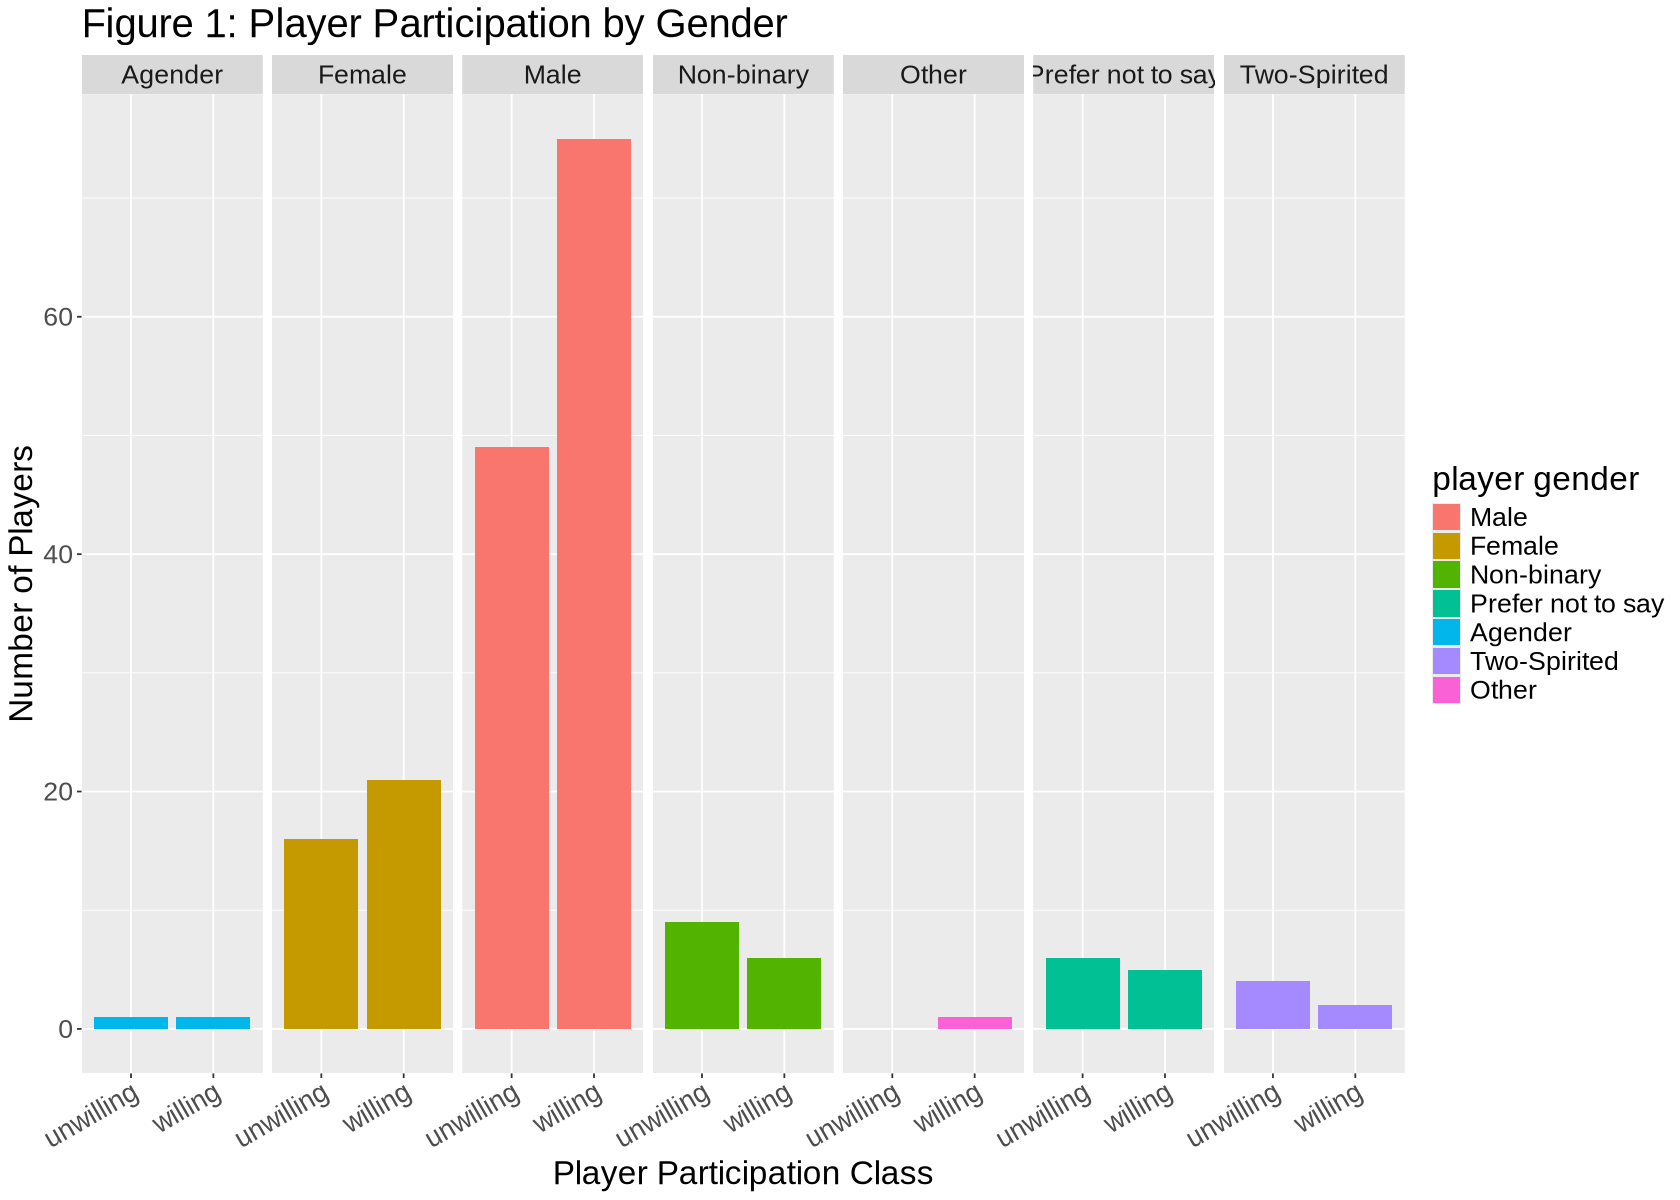

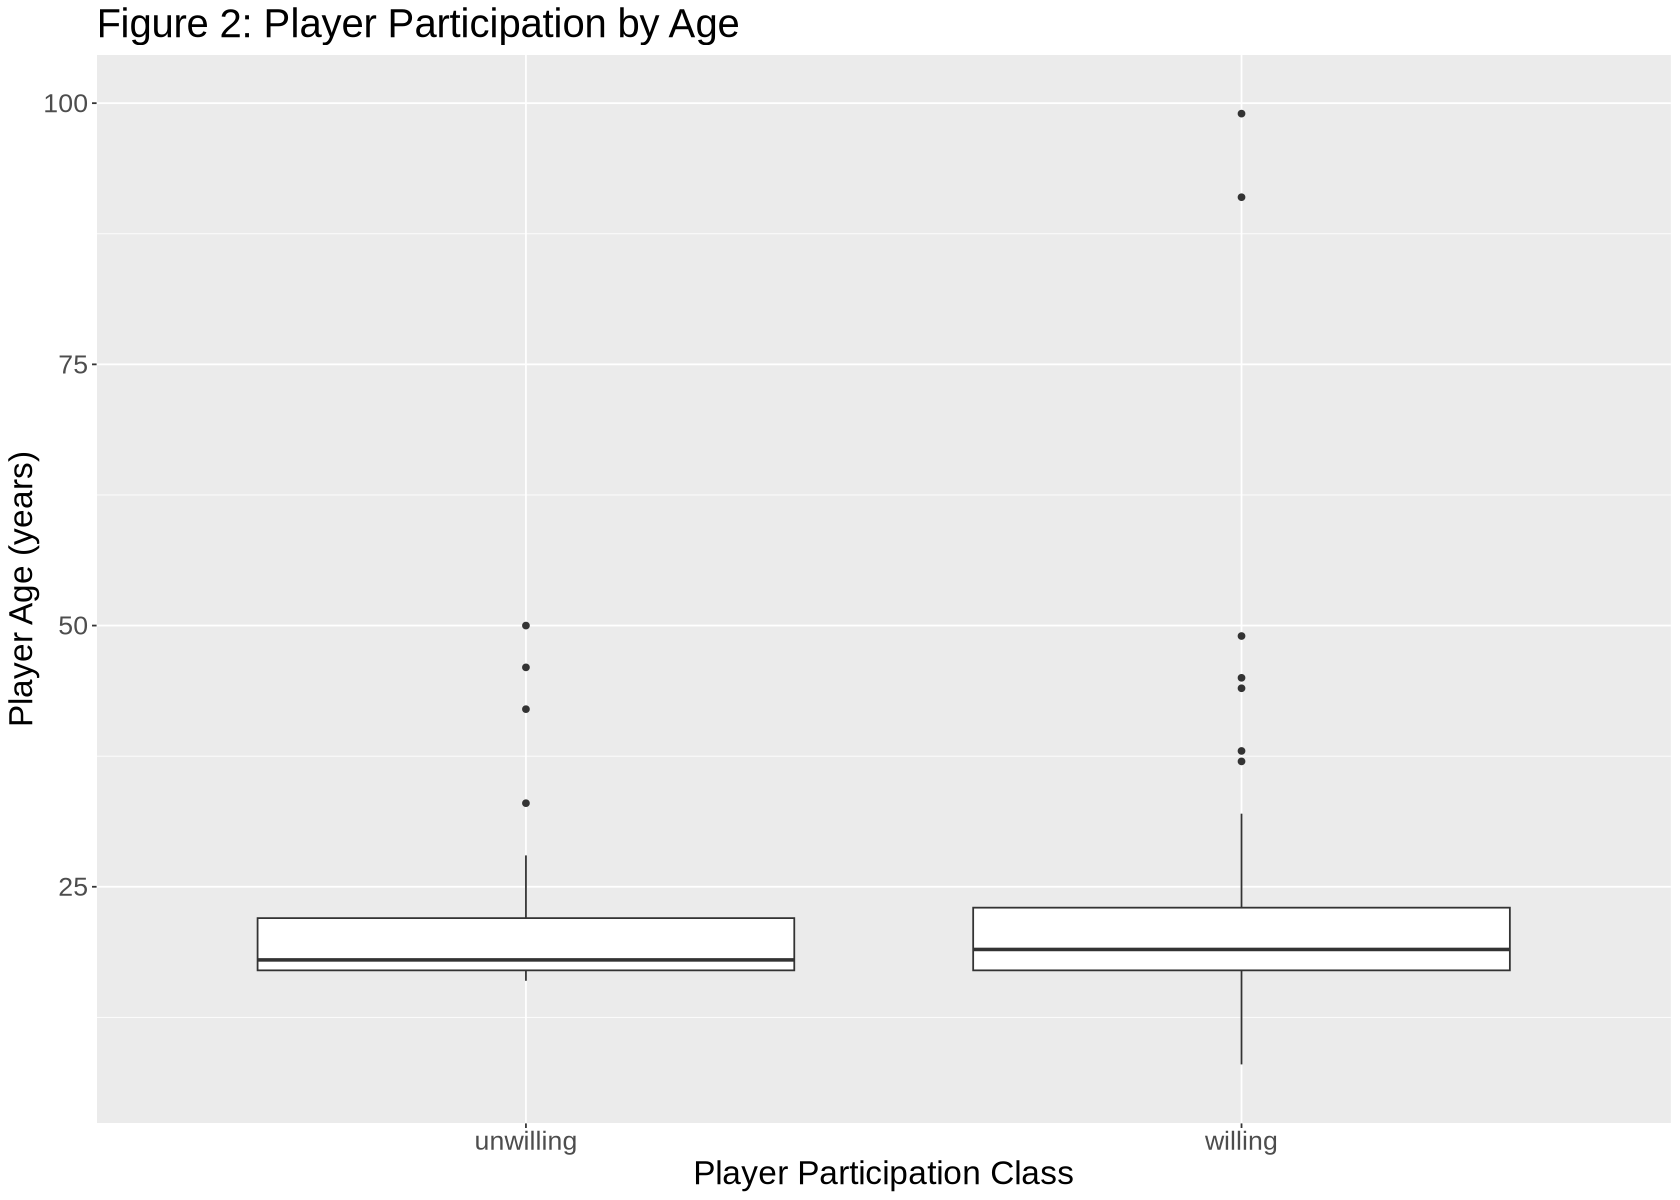

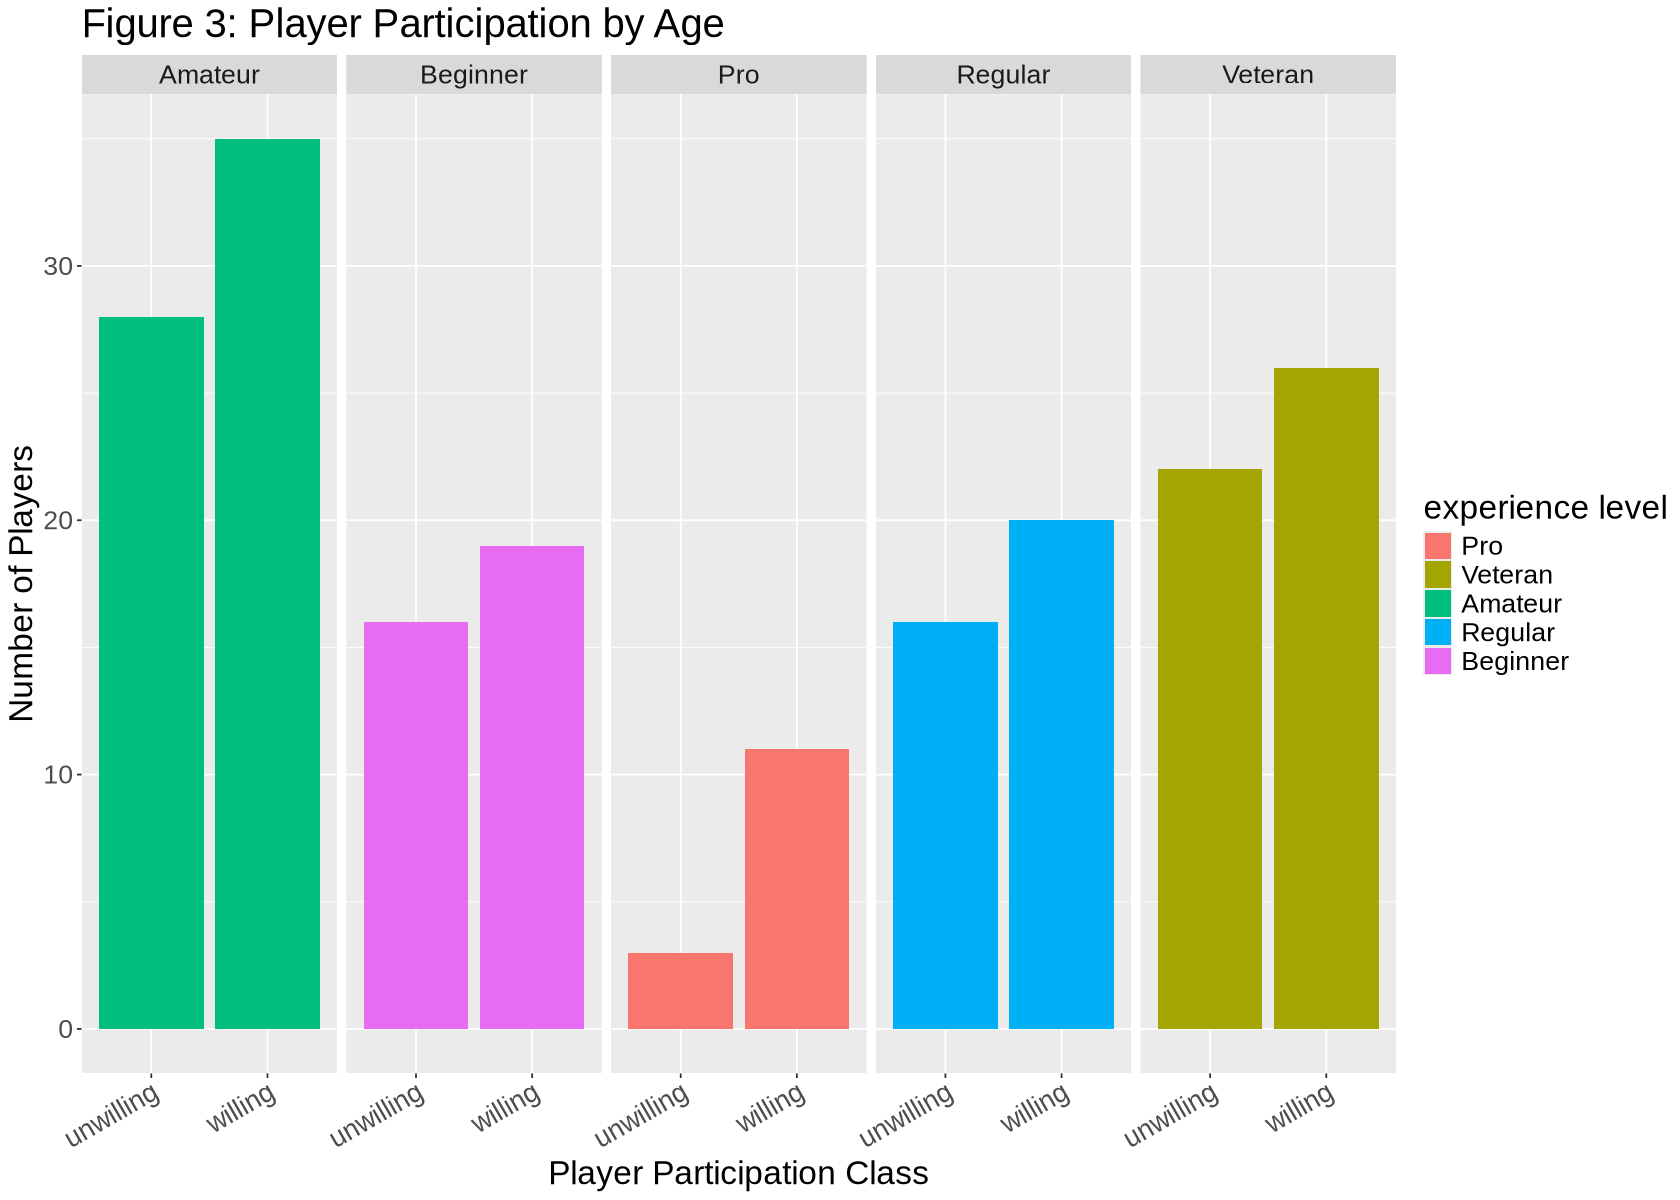

In [4]:
options(repr.plot.width = 14, repr.plot.height = 10)
participation_gender_plot <- player_demographics2 |>
ggplot(aes(x = participation, fill = as_factor(gender))) +
       geom_histogram(position = "identity", stat = "count") +
facet_grid(cols = vars(gender)) +
       xlab("Player Participation Class") +
       ylab("Number of Players") +
       labs(title = "Figure 1: Player Participation by Gender", fill = "player gender") +
       theme(text = element_text(size = 20),
            legend.position = "right",
            legend.direction = "vertical",
            axis.text.x = element_text(angle = 30, hjust = 1))

participation_age_plot <- player_demographics2 |>
ggplot(aes(x = participation, y = age)) +
geom_boxplot() +
ylim(c(7,100)) +
xlab("Player Participation Class") +
ylab("Player Age (years)") +
labs(title = "Figure 2: Player Participation by Age") +
theme(text = element_text(size=20),
      legend.position = "right",
      legend.direction = "vertical")

participation_experience_plot <- player_demographics2 |>
ggplot(aes(x = participation, fill = as_factor(experience))) +
       geom_histogram(position = "identity", stat = "count") +
facet_grid(cols = vars(experience)) +
       xlab("Player Participation Class") +
       ylab("Number of Players") +
       labs(title = "Figure 3: Player Participation by Age", fill = "experience level") +
       theme(text = element_text(size = 20),
            legend.position = "right",
            legend.direction = "vertical",
            axis.text.x = element_text(angle = 30, hjust = 1))

participation_gender_plot
participation_age_plot
participation_experience_plot

#### Summary statistics

Before calculating summary statistics, any players who were unwilling to play were filtered out. This is to make sure the summaries are only those related to players that would actually play the game. Summaries for variables such as hours played and player gender, age, and experience would otherwise be skewed by players who had zero hours logged, and thus didn't actually contribute data.

By gender identity, two-spirited players had the lowest hours played on average, while non-binary players had the highest. By experience level, veteran players (surprisingly) had the lowest hours played on average, while regular players had the highest hours played by a wide margin. The average ages at each experience level were all relatively homogenous, between 20 and 23 years old. The average player age for each gender was a bit less homogenous than for experience level, but (excluding two-spirit and other) were still in this range of 20 to 23 years old.

At this point, it is important to point out one more issue with the dataset that may be relevant later when doing predictive analysis. While there is a good amount of players of the gender identity male, female, and non-binary, there are comparatively few players of the other gender identities. As such, some summary statistics are a little... iffy, to say the least. In the gender and average player age tibble, we can see that the average age for Two-Spirited people and people who chose other is 33 and 91 years respectively (the latter being so drastically different because there is only a single player in the sample with this gender identity, who happened to also be very different in age). This differs heavily from the other gender identity average ages, as well as the average ages for experience level. Since there are not enough players of these two gender demographics in the data set, the summary statistics we get for them may not actually be representative of what is actually accurate for these demographics. This may also be an issue with agender players, and players who prefer not to say their gender identity, since there are also few of those people in our dataset.

In [5]:
gender_avg_hours <- player_demographics2 |>
filter(participation == "willing") |>
select(gender, played_hours) |>
group_by(gender) |>
summarize(avg_hours_played = mean(played_hours))
gender_avg_hours

gender_avg_age <- player_demographics2 |>
filter(participation == "willing") |>
select(gender, age) |>
group_by(gender) |>
summarize(avg_player_age = mean(age))
gender_avg_age

experience_avg_hours <- player_demographics2 |>
filter(participation == "willing") |>
select(experience, played_hours) |>
group_by(experience) |>
summarize(avg_hours_played = mean(played_hours))
experience_avg_hours

experience_avg_age <- player_demographics2 |>
filter(participation == "willing") |>
select(experience, age) |>
group_by(experience) |>
summarize(avg_player_age = mean(age))
experience_avg_age

gender,avg_hours_played
<chr>,<dbl>
Agender,12.5000
Female,18.7381
Male,6.8240
Non-binary,37.2000
Other,0.2000
Prefer not to say,0.8200
Two-Spirited,0.2500


gender,avg_player_age
<chr>,<dbl>
Agender,27.00000
Female,22.95238
Male,19.98667
Non-binary,18.16667
Other,91.00000
Prefer not to say,21.60000
Two-Spirited,58.00000


experience,avg_hours_played
<chr>,<dbl>
Amateur,10.831429
Beginner,2.300000
Pro,3.309091
Regular,32.775000
Veteran,1.196154


experience,avg_player_age
<chr>,<dbl>
Amateur,20.71429
Beginner,22.05263
Pro,22.90909
Regular,23.85000
Veteran,21.50000


The majority of players were male, by a considerable amount. The least populous gender identities in the dataset were Two-Spirited, prefer not to say, and other. This information, coupled with the average age summary statistics earlier, shows that male players around age 20 are the demographic that should be targeted to obtain the greatest amount of data, as these demographics seem the most likely to play the game at all. By experience level, the majority of players were of amateur experience.

In [6]:
gender_number_players <- player_demographics2 |>
filter(participation == "willing") |>
select(gender, experience) |>
group_by(gender) |>
count()
gender_number_players

experience_number_players <- player_demographics2 |>
filter(participation == "willing") |>
select(gender, experience) |>
group_by(experience) |>
count()
experience_number_players

gender,n
<chr>,<int>
Agender,1
Female,21
Male,75
Non-binary,6
Other,1
Prefer not to say,5
Two-Spirited,2


experience,n
<chr>,<int>
Amateur,35
Beginner,19
Pro,11
Regular,20
Veteran,26


### Methods & Results

#### Classification with K-Nearest Neighbors  -- Willing vs. Unwilling

A K-nearest neighbors algorithm was used to classify players as either willing or unwilling to contribute time to the server. As previously seen,  players with a nonzero `played_hours` value were described as willing to contribute. The nominal variables gender and experience were indexed for usability in the recipe:

<table>
<tr><th>Gender Index </th><th>Experience Index</th></tr>
<tr><td>

| Gender identity    | Corresponding number |
| ------------------ | -------------------- |
| Male               | 1                    |
| Female             | 2                    |
| Non-binary         | 3                    |
| Agender            | 4                    |
| Other              | 5                    |
| Prefer not to say  | 6                    |
| Two-Spirited       | 7                    |

</td><td>
    
| Experience level   | Corresponding number |
| ------------------ | -------------------- |
| Amateur            | 1                    |
| Beginner           | 2                    |
| Pro                | 3                    |
| Regular            | 4                    |
| Veteran            | 5                    |

</td></tr> </table>

The dataframe was split into training and testing sets consisting of 75% and 25% respectively of the original `players.csv` dataset. Our recipe was set to predict participation (willing/unwilling) from the modified gender and experience variables, as well as age.

In [7]:
player_demographics2 <- player_demographics2 |>
mutate(participation = as_factor(participation)) |>
mutate(gender_number = case_when(gender == "Male" ~ 1,
                                gender == "Female" ~ 2,
                                gender == "Non-binary" ~ 3,
                                gender == "Agender" ~ 4,
                                gender == "Other" ~ 5,
                                gender == "Prefer not to say" ~ 6,
                                gender == "Two-Spirited" ~ 7)) |>
mutate(experience_number = case_when(experience == "Amateur" ~ 1,
                                experience == "Beginner" ~ 2,
                                experience == "Pro" ~ 3,
                                experience == "Regular" ~ 4,
                                experience == "Veteran" ~ 5))
head(player_demographics2)

set.seed(200)

player_split <- initial_split(player_demographics2, prop = 0.75, strata = participation)
player_train <- training(player_split)
player_test <- testing(player_split)

player_recipe <- recipe(participation ~ gender_number + age + experience_number, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

experience,played_hours,gender,age,participation,gender_number,experience_number
<chr>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<dbl>
Pro,30.3,Male,9,willing,1,3
Veteran,3.8,Male,17,willing,1,5
Veteran,0.0,Male,17,unwilling,1,5
Amateur,0.7,Female,21,willing,2,1
Regular,0.1,Male,21,willing,1,4
Amateur,0.0,Female,17,unwilling,2,1


Before creating a model specification to predict a player's participation status, the classification model was first tuned. The training data was cross-validated, with 5 folds. The sequence of neighbors used was between 1 and 40, and each neighbor was stepped by one. A recipe was made with the recipe and model, metrics were collected, and accuracy was filtered. 

In [8]:
set.seed(200)

player_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

player_vfold <- vfold_cv(player_train, v = 5, strata = participation)
player_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 1))

player_results <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_spec) |>
  tune_grid(resamples = player_vfold, grid = player_vals) |>
  collect_metrics() |>
filter(.metric == "accuracy")
head(player_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4652381,5,0.03358409,Preprocessor1_Model01
2,accuracy,binary,0.4452381,5,0.03269803,Preprocessor1_Model02
3,accuracy,binary,0.5085714,5,0.05428154,Preprocessor1_Model03
4,accuracy,binary,0.5480952,5,0.03489862,Preprocessor1_Model04
5,accuracy,binary,0.4661905,5,0.03696539,Preprocessor1_Model05
6,accuracy,binary,0.4723810,5,0.04803155,Preprocessor1_Model06


A plot of accuracy versus number of neighbors was created to compare K values, and the K value with the highest accuracy (K = 33) was pulled. The graph of accuracy over K was nonlinear and uneven. Still, a clear peak at K = 33 stands considerably higher in accuracy compared to other tested values for this model, even if an accuracy of 59% is generally considered low.

[1] 33

[1] 0.5895238

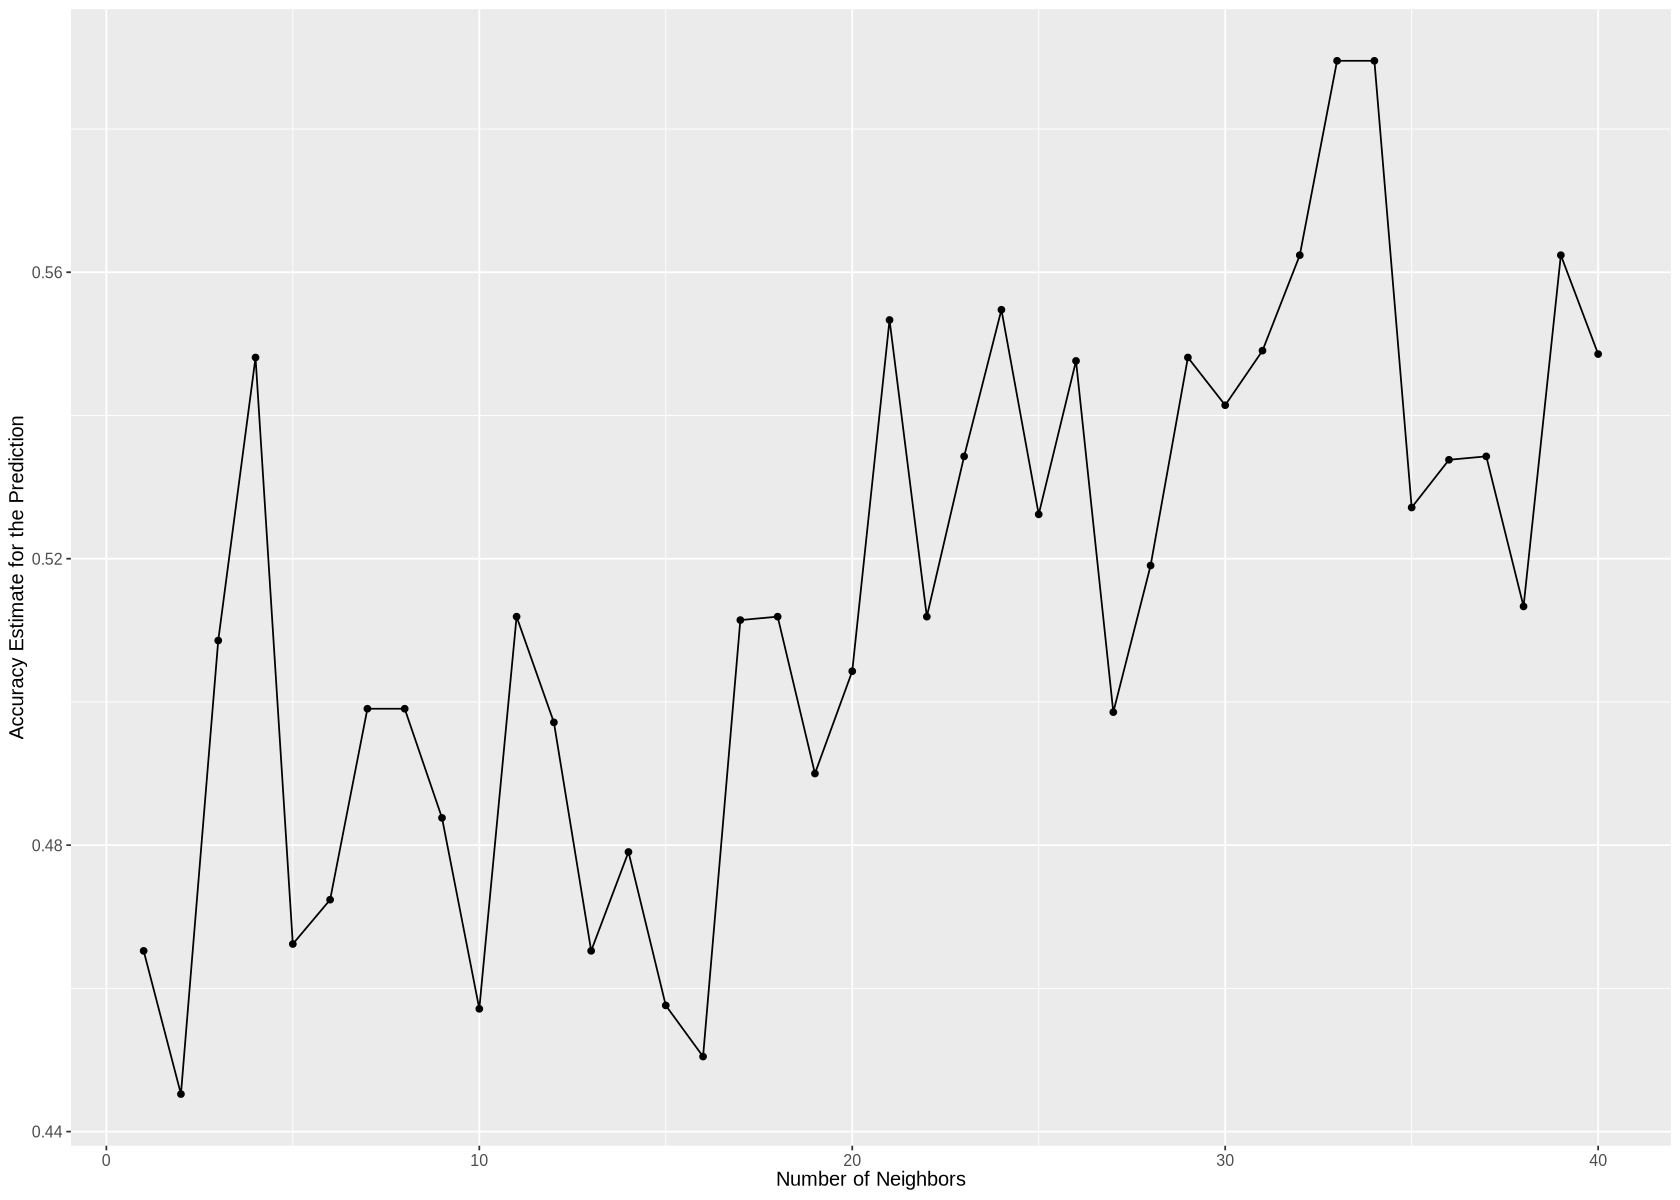

In [9]:
accuracy_vs_k <- ggplot(player_results, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Neighbors", y = "Accuracy Estimate for the Prediction") +
  theme(text = element_text(size = 12))
accuracy_vs_k

best_k <- player_results |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

best_accuracy <- best_k <- player_results |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(mean)
best_accuracy

A final model was generated using the previously pulled best K value. The workflow was fit onto the training split, and the fitted data was used to predict on the testing split. Accuracy, precision, and recall were all measured for the model:

| Metric             | Value                |
| ------------------ | -------------------- |
| Accuracy           | 0.52                 |
| Precision          | 0.58                 |
| Recall             | 0.54                 |

The accuracy of the model when applied to the testing split was slightly lower than that on the training split at 52%. Precision and recall were 58%, and 54% respectively. A confusion matrix comparing prediction and truth is also presented:

|                    | Truth                   |
| ------------------ | ----------------------- |
| **Prediction**     | Willing&nbsp;&nbsp;&nbsp;Unwilling|
| Willing            | 15&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;11|
| Unwilling          | 13&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;11|

In [10]:
set.seed(200)

bestk_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 33) |>
  set_engine("kknn") |>
  set_mode("classification")

player_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(bestk_spec) |>
  fit(data = player_train)

player_test_predictions <- predict(player_fit, player_test) |>
  bind_cols(player_test)
head(player_test_predictions)

.pred_class,experience,played_hours,gender,age,participation,gender_number,experience_number
<fct>,<chr>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<dbl>
willing,Amateur,0.0,Female,17,unwilling,2,1
unwilling,Veteran,1.6,Female,23,willing,2,5
unwilling,Veteran,0.0,Non-binary,17,unwilling,3,5
willing,Amateur,0.0,Male,22,unwilling,1,1
willing,Beginner,0.0,Female,17,unwilling,2,2
willing,Beginner,1.0,Male,17,willing,1,2


In [11]:
levels <- player_test_predictions |>
pull(participation) |>
levels()
levels

[1] "willing"   "unwilling"

In [12]:
accuracy <- player_test_predictions |>
  metrics(truth = participation, estimate = .pred_class) |>
  filter(.metric == "accuracy")

precision <- player_test_predictions |>
    precision(truth = participation, estimate = .pred_class, event_level="first")

recall <- player_test_predictions |>
  recall(truth = participation, estimate = .pred_class, event_level = "first")

confusion <- player_test_predictions |>
             conf_mat(truth = participation, estimate = .pred_class)

### Discussion


After analyzing the data, two "kinds" of players most likely to contribute data to the study: male and female players in their 20s. However, the three kinds of players that would contribute the most data if recruited were determined to be female, non-binary, and agender players.
- Male players comprised 67.6% of willing participants but had a low average of logged hours.
- Female players (18% of willing participants) logged more than double their male counterparts.

Agender and non-binary players had low willingness percentages but high hours. 
- Non-binary players, despite representing only 5.4% of players, had the highest average of logged hours at 37.2 hours and had an average age of 18 years.
- While there was only one willing, 27-year-old agender player, who was 27 years old, they logged 12.5 hours.

Notably, the highest playtimes were observed in younger players: players with 200+ hours logged were male (17 years) and Non-binary (20 years). The players with 100+ hours were both female, aged 16 and 19.

In terms of player experience, amateur and veteran players constituted the largest portion of willing participants. However, the variation in the number of observations between player experience levels was not nearly as dramatic as that for age and gender. Average logged hours were similar across all experience levels, ranging from 21 to 24 hours. Thus, experience level does not appear to significantly influence willingness to play or hours contributed.

From these summarized findings, the most effective targets for recruitment (in terms of gender) are male players due to observation abundance, and Non-binary players due to their high playtime averages. Additionally, younger players (preteens to young adults) contributed unusually high playtimes, making age another critical factor in recruitment strategies. Lastly, in terms of experience, targeting amateur and veteran players would be the most effective when regarding their proportions in the dataset rather than hours logged.

These results largely align with initial expectations. For instance, the prominence of male players and younger participants aligns with stereotypes within the gaming community. Additionally, we expected that both amateur and veteran players showed a willingness to play, though the motivations and patterns of these groups may differ. Amateurs are often motivated by curiosity and a desire to learn, leading them to dedicate more time to playing the game to improve their skills and explore. Veterans, on the other hand, are likely driven by their established connection to the game and their sense of mastery, making them reliable participants.

These insights carry significant implications for the game developers, marketers, and researchers:
1. Game developers can utilize these insights to tailor game features to specific demographics. For instance, younger players consistently contribute high playtime, potentially due to the competitive or progression-based elements of Minecraft. Additionally, the high playtime of Non-binary and agender players suggests an opportunity to offer more inclusive options in different aspects of the game to foster a welcoming environment for underrepresented groups.
2. Given that the majority of players with the highest playtimes are preteens to young adults, marketing efforts should prioritize younger demographics, focusing on platforms like PC gaming where this group is most active. According to the `ESA’s` 2024 report, younger players dominate PC and console gaming, aligning with the dataset. However, the report also notes that the average U.S. gamer is 34 years old and primarily uses mobile devices. This suggests an opportunity to broaden the game’s appeal by incorporating multi-platform accessibility to engage older audiences.
3. The relatively small dataset of `players.csv.` with 196 observations highlights the need for additional data to better understand trends across different age groups and platforms. Expanding data collection to include mobile and console players or more diverse demographics could improve the reliability and applicability of future insights.

Further, these findings can lead to further study on its own: 
- Which strategies could the research team employ that would best allow them to meet their quota?
- Is there a connection between age and player experience?
- Why do "Pro" players seem to contribute less data than Amateur, or Veteran players?
- How can this research team aim their study toward Amateurs, and Veterans simultaneously?
- What other factors, such as geographic region or cultural background, might influence player behaviour and engagement?

### Citations

“2024 Essential Facts About the U.S. Video Game Industry.” Entertainment Software Association, Entertainment Software Association, 15 May 2024, www.theesa.com/resources/essential-facts-about-the-us-video-game-industry/2024-data/. 